In [2]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive/surely_not_sarcasm_data/'

Mounted at /content/drive


In [ ]:
!pip install contractions
!cp -r '$root/utils' .

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras
import pickle

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Dense, InputLayer, Embedding, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Dropout, Bidirectional, BatchNormalization, LSTM, Attention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2

from utils.preprocessing import WordEmbeddings
from utils.evaluation import plot_history, evaluate, show_errors

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.2);

# prepare data

In [5]:
data = pickle.load(open(root+'preprocessed_data_0604', 'rb'))
raw_data = pickle.load(open(root+'raw_data_0604', 'rb'))

In [6]:
vocab_size = 10000
input_dim = vocab_size + 2 # one for padding, one for oov token

In [7]:
maxlen = int(data['X_train'].str.split().str.len().quantile(0.9))
maxlen_par = int(data['X_train_par'].str.split().str.len().quantile(0.9))

In [8]:
tokenizer_layer = TextVectorization(max_tokens=input_dim, output_sequence_length=maxlen, standardize=None)
tokenizer_layer.adapt(data['X_train'])

In [9]:
# tokenizer_par_layer = TextVectorization(max_tokens=input_dim, output_sequence_length=maxlen_par, standardize=None)
# tokenizer_par_layer.adapt(data['X_train_par'])

# attention + bi-LSTM + CNN
*Sarcasm Detection Using Soft Attention-Based  Bidirectional Long Short-Term Memory Model With Convolution Network*  
02.04.2022

In [10]:
vec_len = 200

wordemb = WordEmbeddings()
emb_matrix_comment = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer_layer.get_vocabulary(), root=root)

coverage: 0.9813


In [12]:
input_layer =  keras.Input(shape=(1,), dtype=tf.string)
tokenize_comment = tokenizer_layer(input_layer)

x = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
            mask_zero=True, weights=[emb_matrix_comment], trainable=True,
            embeddings_regularizer=L1L2(l1=5e-6, l2=5e-6))(tokenize_comment)

x = Bidirectional(LSTM(200, return_sequences=True, dropout=0.2), merge_mode=None)(x)
x = Attention()(x)

x = Conv1D(100, 3, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Conv1D(100, 3, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Conv1D(100, 3, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.4)(x)

x = Flatten()(x)
x = Dense(100, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)

model = keras.Model(inputs=[input_layer], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(data['X_train'], data['y_train'], epochs=50, batch_size=128, callbacks=[es],
                validation_data=(data['X_val'], data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 431s 68ms/step - loss: 1.2856 - accuracy: 0.6993 - val_loss: 0.6474 - val_accuracy: 0.7253
Epoch 2/50
6002/6002 [==============================] - 401s 67ms/step - loss: 0.6253 - accuracy: 0.7258 - val_loss: 0.6019 - val_accuracy: 0.7342
Epoch 3/50
6002/6002 [==============================] - 400s 67ms/step - loss: 0.6020 - accuracy: 0.7348 - val_loss: 0.5897 - val_accuracy: 0.7405
Epoch 4/50
6002/6002 [==============================] - 399s 67ms/step - loss: 0.5942 - accuracy: 0.7403 - val_loss: 0.5896 - val_accuracy: 0.7438
Epoch 5/50
6002/6002 [==============================] - 396s 66ms/step - loss: 0.5901 - accuracy: 0.7453 - val_loss: 0.5854 - val_accuracy: 0.7463
Epoch 6/50
6002/6002 [==============================] - 397s 66ms/step - loss: 0.5876 - accuracy: 0.7489 - val_loss: 0.5863 - val_accuracy: 0.7480
Epoch 7/50
6002/6002 [==============================] - 398s 66ms/step - loss: 0.5857 - accuracy: 0.7531 - val_loss: 0

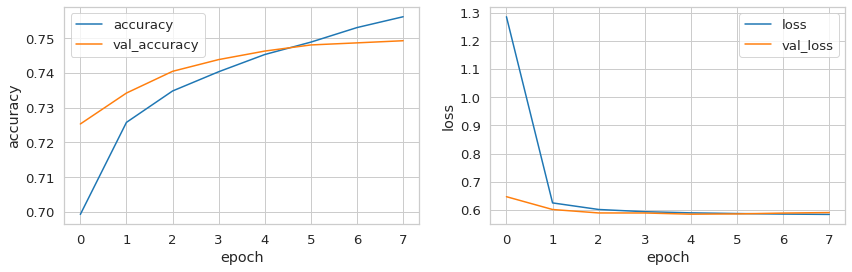

In [13]:
plot_history(fit)

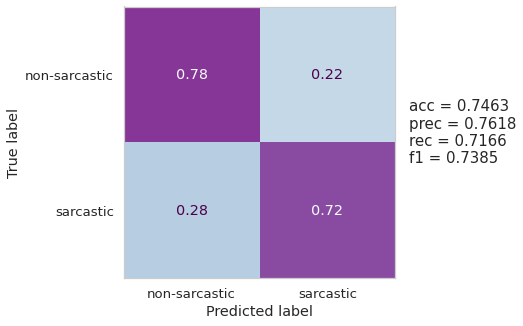

In [14]:
evaluate(model, data['X_val'], data['y_val'])

In [15]:
model.save(root+'models/att_bilstm_cnn')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/att_bilstm_cnn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/att_bilstm_cnn/assets
